## 线性回归

In [110]:
import math
import time
import numpy as np
import torch

In [111]:
class Timer:  #@save
    """记录多次运行时间。"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器。"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中。"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间。"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和。"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间。"""
        return np.array(self.times).cumsum().tolist()

In [112]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [113]:
c = torch.zeros(n)
timer = Timer()
timer.start()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.7f} sec'

'0.0685825 sec'

In [114]:
timer.start()
d = a + b
f'{timer.stop():.7f} sec'

'0.0000000 sec'

### 正态分布与平方损失

In [115]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma** 2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

### 从零开始实现线性回归

In [116]:
import random
import torch
import matplotlib.pyplot as plt

In [117]:
# 生成数据集
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape(-1, 1)

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
# features中的每一行都包含一个二维数据样本，labels中的每一行都包含一维标签值（一个标量）

In [118]:
print('features: ',features[0], '\nlabels: ', labels[0])

features:  tensor([-0.6469, -1.6809]) 
labels:  tensor([8.6337])


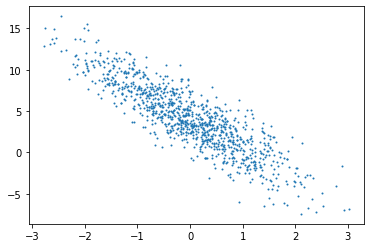

In [119]:
# d2l.set_figsize()
plt.scatter(features[:, 1].detach(), labels.detach().numpy(), 1)

In [120]:
# 读取数据集
def data_iter(batch_size, features, labels):
    num_example = len(features)
    indices = list(range(num_example))
    random.shuffle(indices) # 样本是随机读取的，没有特定的顺序
    for i in range(0, num_example, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_example)])
        yield features[batch_indices], labels[batch_indices]

In [121]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.2655,  0.3614],
        [-1.1601, -1.6587],
        [ 0.7197,  0.3238],
        [-0.4508,  2.1046],
        [-0.7926, -0.2269],
        [-0.1262,  0.6400],
        [ 0.4829,  1.6060],
        [-1.2182, -0.3368],
        [-0.4999, -0.6824],
        [-0.0930,  0.8120]]) 
 tensor([[ 3.5122],
        [ 7.5228],
        [ 4.5368],
        [-3.8480],
        [ 3.3844],
        [ 1.7655],
        [-0.3004],
        [ 2.9016],
        [ 5.5337],
        [ 1.2445]])


In [122]:
# 初始化模型参数
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [123]:
def linreg(X, w, b):
    """线性回归模型。"""
    return torch.matmul(X, w) + b

In [124]:
# 定义损失函数
def squard_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [125]:
# 定义优化算法
def sgd(params, lr, batch_size):
    """小批量梯度下降法"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size #这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和,将它除以批量大小来得到平均值。
            # 梯度清零
            param.grad.zero_()

In [126]:
# 训练
lr = 0.03
num_epochs = 3
net = linreg
loss = squard_loss
for epoch in range(num_epochs):
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        # 批量梯度下降法在 每次迭代时需要计算每个样本上损失函数的梯度并求和
        # 由于变量l并不是一个标量，所以我们可以调用.sum()将其求和得到一个标量
        l = loss(net(X, w, b), y).sum() # l是有关小批量X和y的损失
        l.backward() # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size) # 使用小批量随机梯度下降迭代模型参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.039705
epoch 2, loss 0.000172
epoch 3, loss 0.000050


In [127]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0007, 0.0003], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0006], grad_fn=<RsubBackward1>)


In [128]:
print(true_w, '\n', w)
print(true_b, '\n', b)

tensor([ 2.0000, -3.4000]) 
 tensor([[ 1.9993],
        [-3.4003]], requires_grad=True)
4.2 
 tensor([4.1994], requires_grad=True)


### 线性回归调库实现

In [129]:
# 【生成数据集】
num_inputs = 2
num_example = 1000
true_w = [2,-3.4]
true_b = 4.2
features = torch.tensor(np.random.normal(0, 1, (num_example, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [130]:
# 【读取数据】
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-7.8919e-01,  8.8503e-01],
        [-1.5675e+00, -5.8010e-01],
        [-2.0404e+00,  1.6975e+00],
        [ 6.9755e-01, -1.1090e+00],
        [ 2.9399e+00, -1.1471e+00],
        [-2.0141e+00,  8.6296e-01],
        [ 1.8873e-01,  5.7153e-01],
        [ 2.1848e-03,  7.4979e-02],
        [-3.2803e-01,  7.1755e-01],
        [-1.8551e+00, -5.7018e-01]]) 
 tensor([-0.3948,  3.0323, -5.6592,  9.3559, 13.9723, -2.7554,  2.6390,  3.9560,
         1.0923,  2.4309])


In [131]:
# 【定义模型】
# torch.nn模块: “nn”是neural networks（神经网络）的缩写,该模块定义了大量神经网络的层
# nn的核心数据结构是Module,既可以表示神经网络中的某个层（layer），也可以表示一个包含很多层的神经网络
# 在实际使用中，最常见的做法是继承nn.Module
class LinearNet(torch.nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = torch.nn.Linear(n_feature, 1)
    # forward 定义前向传播
    def forward(self, x):
        y = self.linear(x)
        return y

net = LinearNet(num_inputs)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [132]:
# 使用Sequential
# nn.Sequential来更加方便地搭建网络，Sequential是一个有序的容器，网络层将按照在传入Sequential的顺序依次被添加到计算图中

In [133]:
# 写法一
net = torch.nn.Sequential(
    torch.nn.Linear(num_inputs, 1)
     # 此处还可以传入其他层
)

In [134]:
# 写法二
net = torch.nn.Sequential()
net.add_module('linear', torch.nn.Linear(num_inputs, 1))
#net.add_module

In [135]:
from collections import OrderedDict
net = torch.nn.Sequential(OrderedDict([
    ('linear', torch.nn.Linear(num_inputs, 1))
]))

In [136]:
print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


In [137]:
# et.parameters()来查看模型所有的可学习参数
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[ 0.6034, -0.3682]], requires_grad=True)
Parameter containing:
tensor([0.1636], requires_grad=True)


In [138]:
# 【初始化模型参数】
from torch.nn import init # PyTorch在init模块中提供了多种参数初始化方法
# init.normal_将权重参数每个元素初始化为随机采样于均值为0、标准差为0.01的正态分布。偏差会初始化为零
init.normal_(net[0].weight, mean=0, std=0)
init.constant_(net[0].bias, val=0)
# 如果报错，net[0].weight应改为net.linear.weight

Parameter containing:
tensor([0.], requires_grad=True)

In [139]:
# 【定义损失函数】
loss = torch.nn.MSELoss()

In [140]:
# 【定义优化算法】
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [141]:
# 还可以为不同子网络设置不同的学习率
# optimizer = optim.SGD([
#     {'params': net.subnet1.parameters()},
#     {'params': net.subnet2.parameters(), 'lr': 0.01}
# ], lr=0.03)

In [142]:
# 调整学习率
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.1

In [143]:
# [训练模型]
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter(batch_size, features, labels):
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad()
        l.backward()
        optimizer.step() # step函数中指明批量大小，从而对批量中样本梯度求平均
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 6.804002
epoch 2, loss: 4.344543
epoch 3, loss: 1.224241
epoch 4, loss: 0.212904
epoch 5, loss: 0.067191
epoch 6, loss: 0.059571
epoch 7, loss: 0.016093
epoch 8, loss: 0.002443
epoch 9, loss: 0.001180
epoch 10, loss: 0.000544


In [144]:
dense = net[0]
print(true_w, dense.weight)
print(true_b, dense.bias)

[2, -3.4] Parameter containing:
tensor([[ 1.9928, -3.3892]], requires_grad=True)
4.2 Parameter containing:
tensor([4.1871], requires_grad=True)


### 小结
torch.utils.data模块提供了有关数据处理的工具，torch.nn模块定义了大量神经网络的层，torch.nn.init模块定义了各种初始化方法，torch.optim模块提供了很多常用的优化算法